In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import seaborn as sns

# Information Extraction: Text and Generic Features

### Example: San Diego City Employee Salaries
* Recall Lecture 01: Do men and women make similar salaries?
* Follow-up question: Do men and women make similar salaries among those with similar jobs?
    - How to determine "similar jobs?"

In [2]:
salaries = pd.read_csv('https://transcal.s3.amazonaws.com/public/export/san-diego-2017.csv')
jobtitles = salaries['Job Title']

In [3]:
jobtitles.value_counts().iloc[:100]

Police Officer            1977
Rec Leader 1               285
Fire Fighter 2             285
Grounds Maint Wrkr 2       270
Asst Eng-Civil             238
                          ... 
Paralegal                   25
Wstwtr Operations Supv      25
Public Works Supv           24
Cement Finisher             24
Student Intern              24
Name: Job Title, Length: 100, dtype: int64

In [4]:
jobtitles.shape[0], jobtitles.nunique()

(12493, 669)

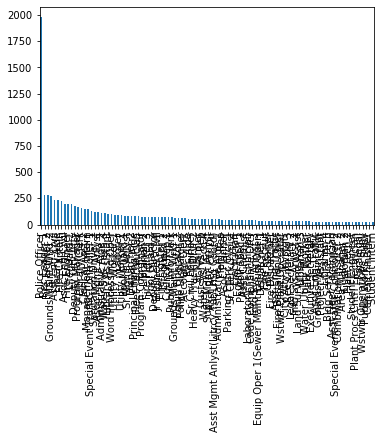

In [5]:
jobtitles.value_counts().iloc[:100].plot(kind='bar')

### Cleaning job titles: assessment
* Can we canonicalize job titles?
* Are they self-consistent?
    - Punctuation? Capitalization? Abbreviations?

In [6]:
# run / rerun
jobtitles.sample(10)

4897       Combination Inspctr 2
1382            Deputy City Atty
7080             Cement Finisher
9658                 Custodian 3
10724             Police Officer
11772          Management Intern
10832                Custodian 1
3294                 Lifeguard 2
2940         Sr Marine Biologist
4060     Master Fleet Technician
Name: Job Title, dtype: object

### Cleaning job titles: step 1
* Is every first letter capitalized?
* What punctuation exists? should it be cleaned?

In [7]:
# Capitalization
jobtitles[(
    jobtitles.str.contains(' [a-z]+ ') | 
    jobtitles.apply(lambda x:x[0].islower())
)]

186            Principal Asst to City Atty
885                 Asst to the Fire Chief
1993                  Asst to the Director
3084               Conf Secretary to Mayor
3378     Conf Secretary to Chief Oper Ofcr
3439           Asst to the Chief Oper Ofcr
4241           Conf Secretary to City Atty
4773           Asst to the Chief Oper Ofcr
4937                  Asst to the Director
6396        Conf Secretary to Police Chief
7841                  Asst to the Director
10446          Asst for Community Outreach
11384              Conf Secretary to Mayor
12398                 Asst to the Director
Name: Job Title, dtype: object

In [8]:
# punctuation: replace with space?
jobtitles[jobtitles.str.contains('[^A-Za-z0-9 ]')].head(15)

95          Deputy City Atty - Unrep
154       Park & Recreation Director
159            Asst Fire Marshal/Civ
176    Fire Captain(Emer Mgmt Coord)
184               Fire Engineer-Mast
218         Deputy City Atty - Unrep
240                Fire Captain-Mast
322      Procurement Spec (Terminal)
374                Fire Captain-Mast
422              Asoc Eng-Electrical
447            Asst Fire Marshal/Civ
481                Fire Captain-Mast
501               Fire Engineer-Mast
562          Cust Info & Billing Mgr
664         Deputy City Atty - Unrep
Name: Job Title, dtype: object

### Cleaning job titles: step 1
* Remove: to, the, for
* Replace: non-alphanumeric with space
* Replace multiple spaces with one space

In [9]:
jobtitles = (
    jobtitles
    .str.replace(' to| the| for', '')  # include the spaces! (why?)
    .str.replace("[^A-Za-z0-9' ]", ' ')
    .str.replace("'", '')
    .str.replace(' +', ' ')
)

In [10]:
jobtitles.sample(10)

9173                Lake Aide 2
3829           Deputy City Atty
95       Deputy City Atty Unrep
5002        Sr Public Info Ofcr
3995                 Sr Planner
2638             Asoc Eng Civil
7508           Water Sys Tech 3
11042                  Rec Aide
6702        Sr Engineering Aide
1459               Fire Captain
Name: Job Title, dtype: object

### Cleaning job titles: abbreviations 

* Which job titles are inconsistently described?
    - Librarian? Engineer? Director?

In [11]:
jobtitles[jobtitles.str.contains('Libr')].value_counts()

Library Aide              232
Library Clerk             158
Library Assistant         102
Librarian 2                76
Librarian 3                30
Librarian 4                28
Library Technician          8
Librarian 1                 7
Supv Librarian              5
Deputy Library Dir          2
Librarian 3 Law Librn       1
City Librarian              1
Sr Library Tech             1
Name: Job Title, dtype: int64

In [12]:
jobtitles[jobtitles.str.contains('Eng')].value_counts()

Asst Eng Civil                              238
Asoc Eng Civil                              198
Fire Engineer                               197
Principal Engrng Aide                        82
Jr Engineer Civil                            69
Sr Civil Engineer                            57
Asst Eng Traffic                             34
Asoc Eng Traffic                             29
Student Engineer                             25
Structural Engrng Asoc                       16
Sr Traffic Engineer                          15
Sr Engineering Aide                          12
Asoc Eng Electrical                          12
Structural Engrng Sr                          9
Asst Eng Civil Cntrct Spec                    8
Asst Eng Electrical                           8
Asoc Eng Mechanical                           8
Asoc Eng Civil Sr Cntrct Spec                 7
Structural Engrng Asst                        6
Asoc Commctns Eng                             4
Asoc Eng Civil Asoc Eng Geol            

In [13]:
jobtitles[jobtitles.str.contains('Dir')].value_counts()

Deputy Director                    71
Asst Rec Ctr Dir                   49
Rec Cntr Dir 3                     33
Asst Deputy Director               16
Rec Cntr Dir 2                     14
Department Director                11
Rec Cntr Dir 1                     10
Executive Director                 10
Asst Department Director            8
Asst Director                       4
Deputy Pers Director                2
Deputy Library Dir                  2
Public Utilities Director           2
Asst Planning Director              1
Asst Metro Wstwtr Dir               1
Deputy Planning Director            1
Real Estate Assets Dir              1
Park Recreation Director            1
Asst Pers Director                  1
Environmental Services Dir          1
Risk Management Director            1
Planning Director                   1
Asst Environmental Services Dir     1
Development Services Dir            1
Personnel Director                  1
Name: Job Title, dtype: int64

### The limits of canonicalization
* How do we find which common words to map a job title to?
    - E.g. pattern matching on 'Eng' or 'Libr'
* What about other titles? (there are too many!)
* Adjectives vs Nouns have different meanings
    - Junior/Senior/Director vs Police/Fire/Engineer

### The limits of canonicalization

Naive procedure: 
1. Compute most common words (distribution of words in the dataset)
2. Select "relevant" words using domain expertise  (Police vs Asst)
3. Check if a given word is contained in a given job title.

In [14]:
# compute counts of all words (together)
bow = jobtitles.str.split().sum()    #splits on space and sums
#bow
words = pd.Series(bow).value_counts()
#words
words.head(10)

2          2278
Police     2160
Officer    2001
1          1555
Fire       1017
Asst        751
Aide        615
Civil       584
Eng         559
Sr          531
dtype: int64

In [15]:
len(words)

464

In [16]:
# is a given word in a job-title? count number of occurances of each
jobtypes = pd.DataFrame([], index=salaries.index)
for word in words.index:
    re_pat = '\\b{val}\\b'.format(val = word)
    jobtypes[word] = jobtitles.str.count(re_pat).astype(int)

In [17]:
# number of counts each word appear in every row
jobtypes.head(12)

,2,Police,Officer,1,Fire,Asst,Aide,Civil,Eng,Sr,...,Prop,Lakes,Warehouse,Ed,Emer,Bus,Security,Outrch,Motve,Metro
0,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [18]:
# how many columns? (curse of dimensionality)

len(jobtypes.columns)

464

In [19]:
# number of job titles that contained that word
# most common 20 words
jobtypes.iloc[:,:20].sum()

2          2278
Police     2160
Officer    2001
1          1555
Fire       1017
Asst        751
Aide        615
Civil       584
Eng         559
Sr          531
Asoc        525
Library     503
Rec         499
Anlyst      494
3           481
Tech        472
Maint       444
Supv        444
Fighter     430
Clerk       410
dtype: int64

In [20]:
# What does this represent?
# most common 20 words
# What about those with sum = 0? sum > 1?
jobtypes.iloc[:,:20].sum(axis=1)#.describe()

0        1
1        1
2        1
3        1
4        1
        ..
12488    2
12489    0
12490    1
12491    2
12492    2
Length: 12493, dtype: int64

### What are the closest job titles to 'Asst Fire Chief'


* Idea: which other job titles share "the most" words in common?
* Implementation: use the 'word vectors' in `jobtypes` to count up matching words.

In [21]:
# what are the closest job titles to:
jobidx = 109
job = jobtitles.iloc[jobidx]
job

'Asst Fire Chief'

In [22]:
job1 = jobtitles.iloc[0]
job1

'Fire Battalion Chief'

In [23]:
# word vectors side-by-side
pd.concat([jobtypes.iloc[0], jobtypes.iloc[109]], axis=1).head(10)

,0,109
2,0,0
Police,0,0
Officer,0,0
1,0,0
Fire,1,1
Asst,0,1
Aide,0,0
Civil,0,0
Eng,0,0
Sr,0,0


In [24]:
# multiply

cnts = pd.concat([jobtypes.iloc[0], jobtypes.iloc[109]], axis=1)

(cnts.iloc[:,0] * cnts.iloc[:,1]).head(10).to_frame()

,0
2,0
Police,0
Officer,0
1,0
Fire,1
Asst,0
Aide,0
Civil,0
Eng,0
Sr,0


In [25]:
# sum the matches
np.sum(cnts.iloc[:,0] * cnts.iloc[:,1])

2

## Solution attempt 1: bag of words
1. Create a list of all words appearing among *all* text ('bag of words')
2. Create a vector, indexed by the distinct words, with counts of the words in that entry.
3. Two text entries are similar if the sum of their matches is large.
    - The sum of their matches is the same as the dot-product of the vectors!

### Discussion Question

Given the list of sentences below:
1. What is the index for the word vectors of the sentences?
2. How close are the word-vectors of the first and second sentence?

In [26]:
sentences = [
    'the fox and the moon',
    'the cow and the moon',
    'the cow and the spoon'
]
pd.Series(sentences).to_frame()

,0
0,the fox and the moon
1,the cow and the moon
2,the cow and the spoon


### Answer

In [27]:
sentences = pd.Series(sentences)
sentences

0     the fox and the moon
1     the cow and the moon
2    the cow and the spoon
dtype: object

In [28]:
words = pd.Series(sentences.str.split().sum()).value_counts()
words

the      6
and      3
moon     2
cow      2
fox      1
spoon    1
dtype: int64

In [38]:
wordvecs = pd.DataFrame([], index=sentences.index)
for word in words.index:
    re_pat = '\\b%s\\b' % word
    wordvecs[word] = sentences.str.count(re_pat).astype(int)
    # print(re_pat)
    
wordvecs

,the,and,moon,cow,fox,spoon
0,2,1,1,0,1,0
1,2,1,1,1,0,0
2,2,1,0,1,0,1


In [30]:
np.sum(wordvecs.iloc[0] * wordvecs.iloc[1])

6

### Bag of Words: Salaries
* Compute the sum of matches among all word vectors and 'Asst Fire Chief'
* Take the job that is the closest match

In [31]:
jobtitles.iloc[jobidx]

'Asst Fire Chief'

In [32]:
jobvec = jobtypes.iloc[jobidx]
jobvec.head(10)

2          0
Police     0
Officer    0
1          0
Fire       1
Asst       1
Aide       0
Civil      0
Eng        0
Sr         0
Name: 109, dtype: int32

In [33]:
# dot product with 'Asst Fire Chief' and *all* other titles
matches = jobtypes.apply(lambda ser: np.dot(jobvec, ser), axis=1)
matches.head(10)

0    2
1    1
2    1
3    2
4    1
5    1
6    2
7    0
8    1
9    2
dtype: int64

In [34]:
jobtitles.loc[matches.sort_values(ascending=False).index].head(10)

174           Asst Fire Chief
885           Asst Fire Chief
109           Asst Fire Chief
0        Fire Battalion Chief
114      Fire Battalion Chief
237      Fire Battalion Chief
215      Fire Battalion Chief
3439     Asst Chief Oper Ofcr
159     Asst Fire Marshal Civ
5988     Fire Battalion Chief
Name: Job Title, dtype: object

## Summary: Bag of Words

* Create an index out of *all* distinct words 
    - The basis for the vector space of words.
* Create vectors for each text entry by computing the counts of words in the entry.
* The dot product between two vectors is proportional to their 'similarity':
    - This defines the **cosine similarity** between vectors via: $$dist(v, w) = 1 - \cos(\theta) = 1 - \frac{v \cdot w}{|v||w|}$$

### Conclusion: Bag of Words
* Bag of words *embeds words into a vector space*
* Can then use clustering (e.g. k-means) to group like words (e.g. into 'job-types')
    - Unfortunately, many clustering techniques don't work well in high dimensions.
* Downside: treats all words as *equally important*.
    - "Asst Fire Chief" vs "Asst Chief Oper Ofcr"

## TF-IDF

Term Frequency / Inverse Document Frequency

### Term Frequency, Inverse Document Frequency

How do we figure out which words are "important" in a document?

1. The most common words often *don't* have much meaning!
2. The very rare words are also less important!

Goal: balance these two observations.

## Term Frequency, Inverse Document Frequency

* The *term frequency* of a word $t$ in a document $d$, denoted ${\rm tf}(t,d)$, is the likelihood of the term appearing in the document.
   * Word that occurs often is important to document meaning.

* The *document frequency* is how often the a words occurs in the entire set of documents.
   * Common words that appear everywhere.


* Question: what are the frequencies for a word "the"? (high/low?)

## What about their ratio? Intuition

The relevance of this word to the document.

$$\frac{{\rm\ TermFrequency}}{{\rm DocumentFrequncy}}$$

* `TF`: High, `DC`: High
* `TF`: High, `DC`: Low
* `TF`: Low, `DC`: High
* `TF`: Low, `DC`: Low

## Term Frequency, Inverse Document Frequency

* The *term frequency* of a word $t$ in a document $d$, denoted ${\rm tf}(t,d)$, is the likelihood of the term appearing in the document.
* The *inverse document frequency* of a word $t$ in a set of documents $\{d_i\}$, denoted ${\rm idf}(t,d)$ is: 

$$\log(\frac{{\rm\ total\ number\ of\ documents}}{{\rm number\ of\ documents\ in\ which\ t\ appears}})$$

* The *tf-idf* of a term $t$ in document $d$ is given by the product: 

$${\rm tfidf}(t,d) = {\rm tf}(t,d) \cdot {\rm idf}(t)$$

In [39]:
# What is the tf-idf of 'cow' in the second 'document'?
sentences.to_frame()

,0
0,the fox and the moon
1,the cow and the moon
2,the cow and the spoon


### Answer

In [40]:
# the term frequency of 'cow' in the second 'document'
tf = sentences.iloc[1].count('cow') / (sentences.iloc[1].count(' ') + 1)
tf

0.2

In [50]:
len(sentences)

3

In [41]:
idf = np.log(len(sentences) / sentences.str.contains('cow').sum())

In [42]:
idf

0.4054651081081644

In [43]:
tf * idf

0.08109302162163289

### TF-IDF of all terms in all documents
* What are the different reasons tf-idf can be zero?
* When is it the largest?

In [44]:
sentences

0     the fox and the moon
1     the cow and the moon
2    the cow and the spoon
dtype: object

In [49]:
words = pd.Series(sentences.str.split().sum())
words

0       the
1       fox
2       and
3       the
4      moon
5       the
6       cow
7       and
8       the
9      moon
10      the
11      cow
12      and
13      the
14    spoon
dtype: object

In [51]:
tfidf = pd.DataFrame([], index=sentences.index)  # dataframe of documents
for w in words.unique():
    re_pat = '\\b%s\\b' % w
    tf = sentences.str.count(re_pat) / (sentences.str.count(' ') + 1)
    idf = np.log(len(sentences) / sentences.str.contains(re_pat).sum())
    tfidf[w] = tf * idf

In [52]:
tfidf

,the,fox,and,moon,cow,spoon
0,0.0,0.219722,0.0,0.081093,0.000000,0.000000
1,0.0,0.000000,0.0,0.081093,0.081093,0.000000
2,0.0,0.000000,0.0,0.000000,0.081093,0.219722


### Summary: TF-IDF

* Term Frequency, Inverse Document Frequency balances:
    - how often a word appears in a document/sentence, with
    - how often a word appears *across* documents.
* For a given document, the word with the highest TF-IDF best summarizes that document.

### Example: State of the Union Addresses

* What are the important words for each address?

In [ ]:
import re
sotu = open('data/stateoftheunion1790-2017.txt').read()

In [ ]:
print(sotu[:20000])

In [ ]:
speeches = sotu.split('\n***\n')[1:]

In [ ]:
len(speeches)

In [ ]:
def extract_struct(speech):
    L = speech.strip().split('\n', maxsplit=3)
    L[3] = re.sub("[^A-Za-z' ]", ' ', L[3]).lower()
    return dict(zip(['speech', 'president', 'date', 'contents'], L))

In [ ]:
df = pd.DataFrame(list(map(extract_struct, speeches)))

In [ ]:
df

In [ ]:
words = pd.Series(df.contents.str.split().sum())

In [ ]:
tfidf = pd.DataFrame([], index=df.index)  # dataframe of documents
tf_denom = (df.contents.str.count(' ') + 1)
for w in words.value_counts().iloc[0:500].index:
    # imperfect pattern match for speed
    re_pat = ' %s ' % w
    tf = df.contents.str.count(re_pat) / tf_denom
    idf = np.log(len(df) / df.contents.str.contains(re_pat).sum())
    tfidf[w] =  tf * idf

In [ ]:
tfidf.head()

In [ ]:
summaries = tfidf.idxmax(axis=1)
summaries

In [ ]:
pd.concat([summaries, df.president], axis=1).groupby('president').apply(lambda x:x[0].unique())

## Features

* A **feature** is a measurable property or characteristic of a phenomenon being observed.
* Synonyms: (explanatory) variable, attribute
* Examples include:
    - a column of a dataset.
    - a derived value from a dataset, perhaps using additional information.
    
We have been creating features to summarize data!

### Examples of features in SD salary dataset

* Salary of employee
* Employee salaries, standardized by job status (PT/FT)
* Gender/age of employees (derived from SSA names; accurate?)
* Job Family associated to a job title (uses text-techniques)
* TF-IDF summary of each state of the union address (topic modeling)

## What makes a good feature?

* Fidelity to Data Generating Process (Consistency).
* Strongly associated to phenomenon of interest ("contains information").
* Easily used in standard modeling techniques (e.g. quantitative and scaled).

Datasets often come with weak attributes; features may need to be "engineered" to convey information.

## Feature Engineering

* The process of creating effective, quantitative attributes from data.
* Transforming heterogeneous data into quantitative data is required for statistical models!
* Similar observations in the data should transform to nearby points in the (Euclidean) feature space.

Effective feature engineering makes (relationships in) data easy to understand!
- Either for a statistical model, or visually for the data scientist.

## The goal of feature engineering

* Find transformations that effectively transform data into effective quantitative variables

* Find functions $\phi:{\rm DATA}\to\mathbb{R}^d$ where similar points $x,y\in {\rm DATA}$ have close images $\phi(x), \phi(y)\in \mathbb{R}^d$

* A "good" choice of features depends on many factors:
    - data type (quantitative, ordinal, nominal),
    - the relationship(s) and association(s) being modeled,
    - the model type (e.g. linear models, decision tree models, neural networks).

### Want to build a linear model:

<div class="image-txt-container">
    
* on a dataset of product review data (X),
* to understand the relationship to product ratings (Y).

<img src="imgs/plane.jpg">

</div>


### Want to build a linear model

* Why can't a linear model be built review data directly?
* What needs to happen to build the model?
* What are concrete steps to take?

|UID|AGE|STATE|HAS_BOUGHT|REVIEW|\||RATING|
|---|---|---|---|---|---|---|
|0|32|NY|True|"Meh."|\||&#10025;&#10025;|
|42|50|WA|True|"Worked out of the box..."|\||&#10025;&#10025;&#10025;&#10025;|
|57|16|CA|NULL|"Hella tots lit yo..."|\||&#10025;|
|...|...|...|...|...|\||...|
|(int)|(int)|(str)|(bool)|(str)|\||(str)|

### Basic Transformations: uninformative features

`UID` was likely used to join the user information (e.g., `age`, and `state`) with some `Reviews` table.  The `UID` presents several questions:
* What is the meaning of the `UID` *number*? 
* Does the magnitude of the `UID` reveal information about the rating?
* Does adding `UID` improve our model?
* **Transformation:** drop the feature.


### Dropping Features

There are certain scenarios where manually dropping features might be helpful:

1. when the features **does not to contain information** associated with the prediction task.  
2. when the feature is **not available at prediction time.**  For example, the feature might contain information collected after the user entered a rating.  This is a common scenario in time-series analysis.


### Basic Transformations: scaling features

`AGE` might contain corrupted or 'clumped' data that requires scaling:
- **Transformation:** apply binning to discretize the data into quartiles.
- **Transformation:** apply non-linear transformation (e.g. log, sqrt).
- **Transformation:** normalize/standardize (z-scale; range).

### Basic Transformations: ordinal encoding

How to encode the `RATING` column as a quantitative variable?
* **Transformation:** "number of &#10025;" to "number".
    - Called *ordinal encoding*: map the ordinal values onto the integer, preserving order.
* Does this preserve "distances" between ratings? (yes).
    

In [ ]:
order_values = ['✩', '✩✩', '✩✩✩', '✩✩✩✩', '✩✩✩✩✩']
ordinal_enc = {y:x for (x,y) in enumerate(order_values)}
ordinal_enc

In [ ]:
df.RATING.replace(ordinal_enc)

### Basic Transformations: one-hot encoding

How to encode the `STATE` column as a quantitative variable?
- How do we make STATE into a meaningful number?
- Ordinal Encoding? AL=1,...,WY=50? (No!)
- **Transformation:** 50 binary variables: `is_AL`,...,`is_WY`.
    

## Nominal feature encoding: One hot encoding

* Transform categorical features into many binary features.
* Given a column `col` with values `A1,A2,...A_N`, define the following quantitative binary columns:

$$\phi_i(x) = \left\{\begin{array}{ll}1 & {\rm if\ } x = A1 \\ 0 &  {\rm if\ } x\neq A1 \\ \end{array}\right. $$

* *Also called:* dummy encoding; indicator variables.

### Example: one hot encoding `STATE`

<div class="txt-image-container">

* A column containing US states transforms into 50 feature columns
* e.g. `phi_CA(x) = 1 if x == 'CA' else 0`
* Each row has *exactly one 1*.
* Many of these columns will be *largely* 0.

<img src="imgs/one-hot.png">

</div>

In [ ]:
df = pd.DataFrame([['NY'], ['WA'], ['CA'], ['NY'], ['OR']], columns=['STATE'])
df

In [ ]:
states = df.STATE.unique()
states

In [ ]:
df['STATE'].apply(lambda x: pd.Series(x == states, index=states, dtype=float))